In [49]:
import sys

from sae_lens.training.evals import run_evals
from sae_lens.training.activations_store import ActivationsStore
import transformer_lens
from tests.unit.helpers import build_sae_cfg
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
import torch
import numpy as np
import datasets
from io import BytesIO

print(sys.version)
%load_ext autoreload
%autoreload 2

DEVICE = "mps"  # or cuda or cpu

3.11.8 (main, Feb 26 2024, 15:36:12) [Clang 14.0.6 ]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

saes, sparsities = get_gpt2_res_jb_saes(device=DEVICE)

100%|██████████| 13/13 [00:24<00:00,  1.89s/it]


In [51]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small", device=DEVICE)
cfg = build_sae_cfg(
    checkpoint_path="./checkpoints",
    train_batch_size=1000,  # TODO i dunno what this is
    total_training_tokens=300 * (10 ** 6),
    context_size=128,
    device=DEVICE,
    d_in=768,
)

dataset = datasets.load_dataset("NeelNanda/openwebtext-tokenized-9b", streaming=True)
activation_store = ActivationsStore.from_config(model, cfg, dataset=dataset['train'])
res = {}
ctx = {
    "suffix": "",
    "n_training_steps": 42,
}


def run_all_evals():
    for name, sae in tqdm(saes.items(), desc="Evaluating SAEs"):
        metrics = run_evals(sae, activation_store, model, ctx)
        res[name] = metrics.as_dict(suffix="")

    with open("gpt2_small_metrics.json", "w") as f:
        json.dump(res, f)


run_all_evals()

Loaded pretrained model gpt2-small into HookedTransformer
Run name: 128-L1-0.002-LR-0.0002-Tokens-1.000e+06
n_tokens_per_buffer (millions): 4.8e-05
Lower bound: n_contexts_per_buffer (millions): 8e-06
Total training steps: 250000
Total wandb updates: 25000
n_tokens_per_feature_sampling_window (millions): 0.0012
n_tokens_per_dead_feature_window (millions): 0.024
We will reset the sparsity calculation 5000 times.
Number tokens in sparsity calculation window: 2.00e+02


Resolving data files:   0%|          | 0/37 [00:00<?, ?it/s]

Evaluating SAEs: 100%|██████████| 13/13 [02:16<00:00, 10.51s/it]


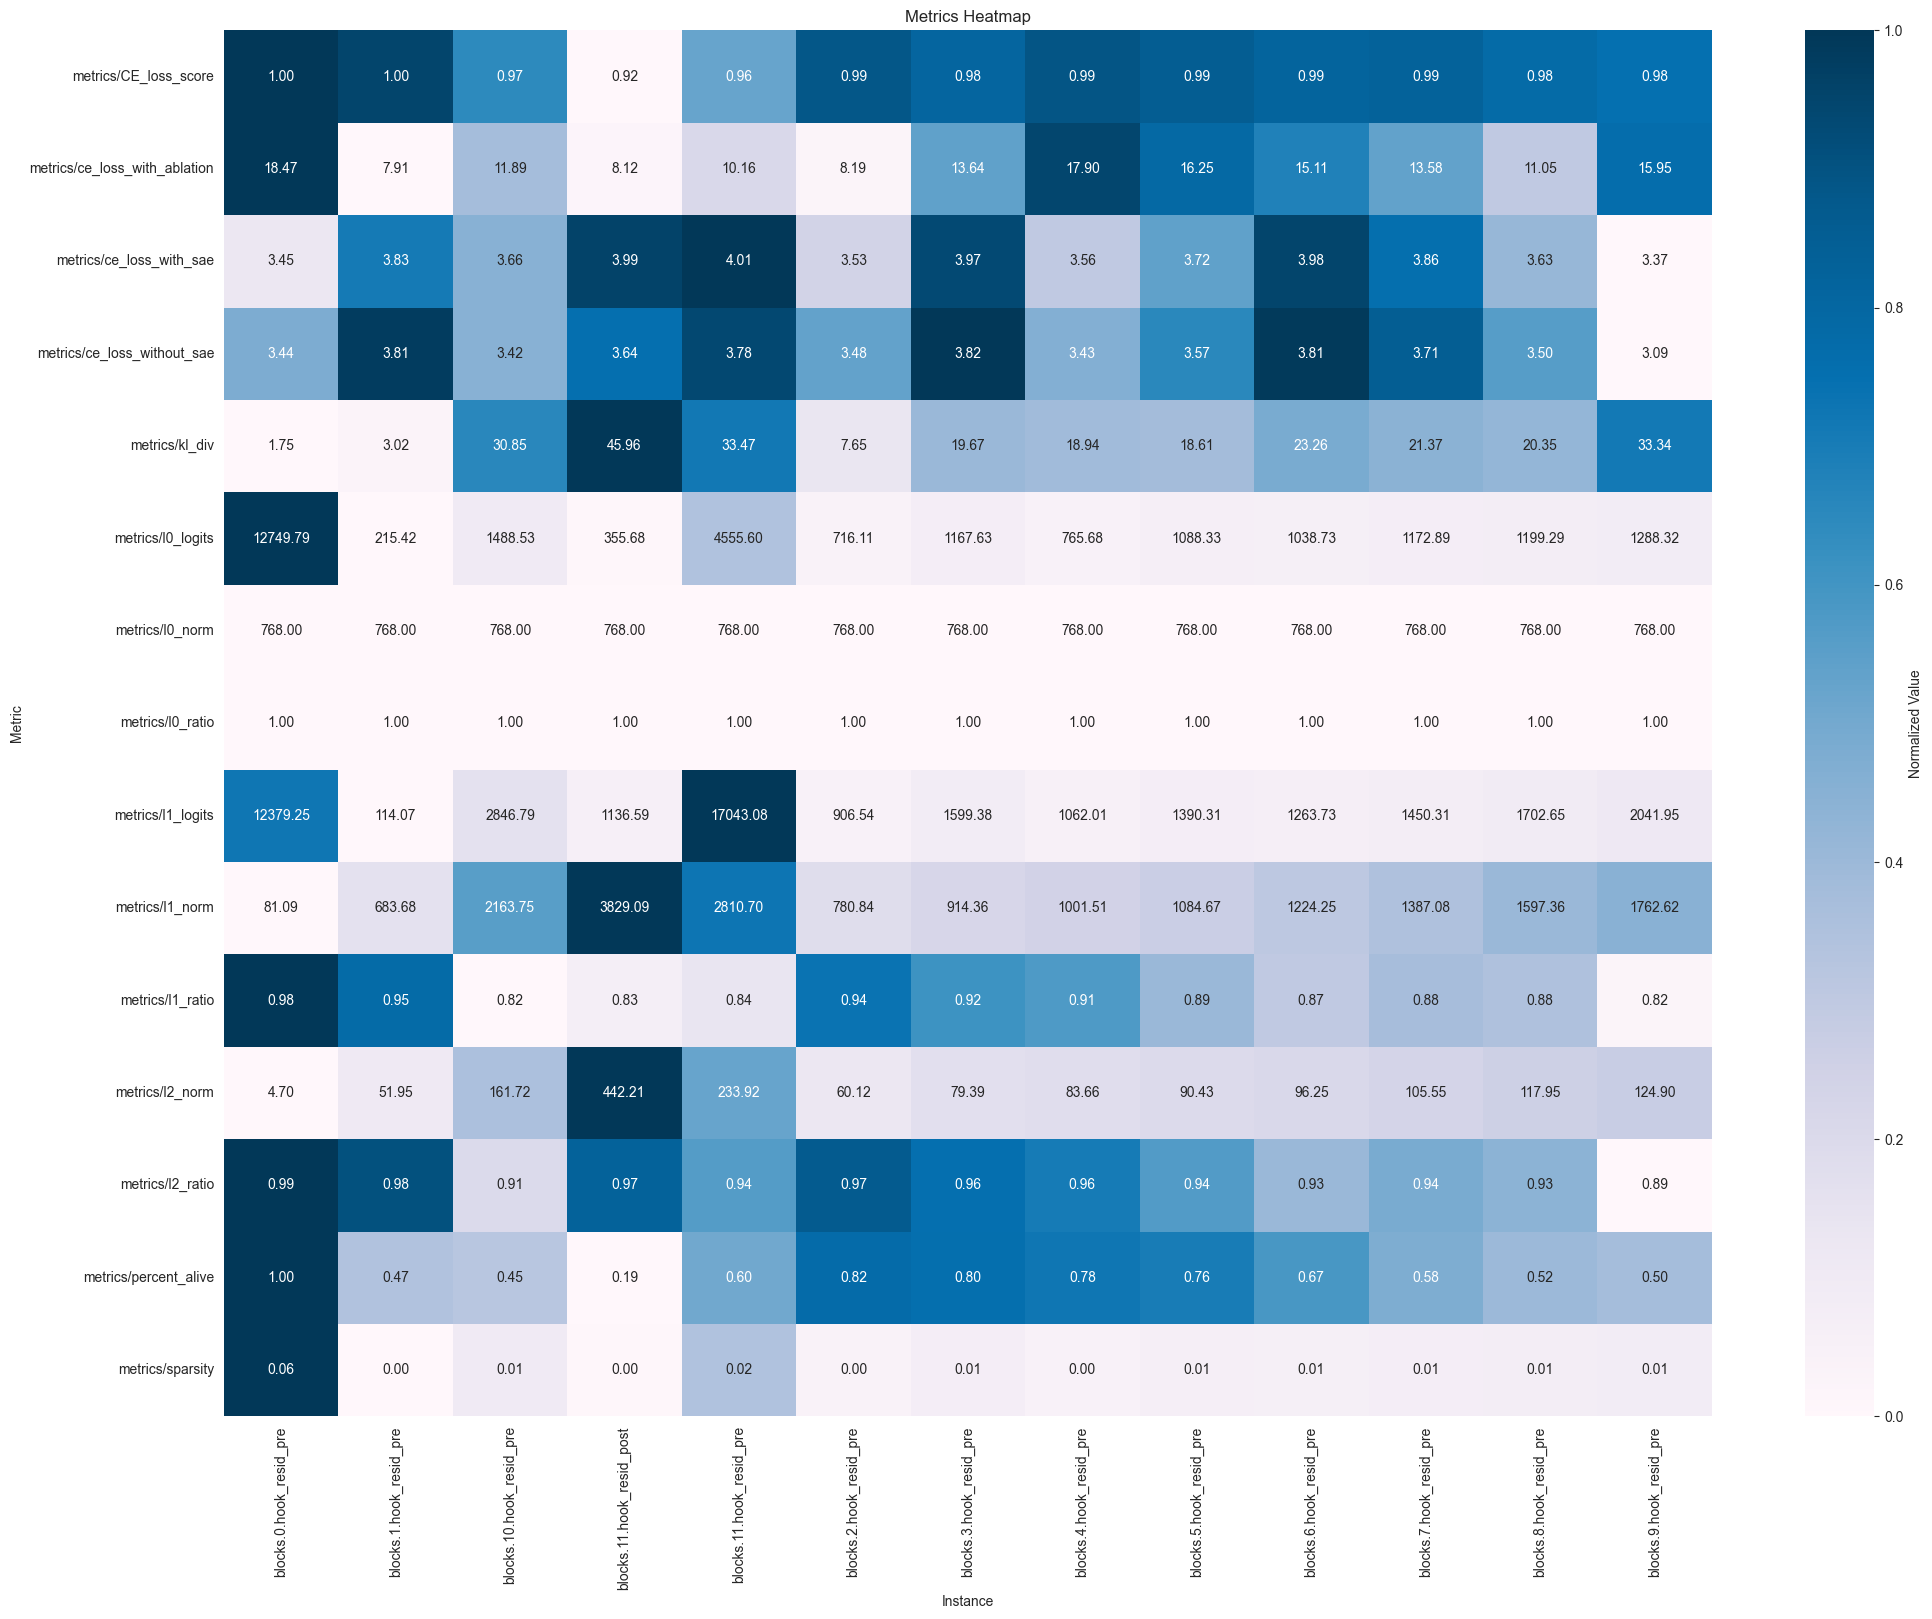

<Figure size 640x480 with 0 Axes>

In [52]:
def create_heatmap(metrics_dict):
    # Convert the nested dictionary to a pandas DataFrame
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')

    # Melt the DataFrame to reshape it for heatmap visualization
    df_melted = pd.melt(df.reset_index(), id_vars='index', var_name='Metric', value_name='Value')

    # Create a pivot table to reshape the data for the heatmap
    df_pivot = df_melted.pivot(index='Metric', columns='index', values='Value')

    # Normalize the values within each row for color scaling
    def normalize_row(row):
        if row.max() == row.min():
            return pd.Series(0.0, index=row.index)
        else:
            return (row - row.min()) / (row.max() - row.min())

    df_normalized = df_pivot.apply(normalize_row, axis=1)

    # Create a custom diverging color palette using vlag
    cmap = sns.color_palette("PuBu", as_cmap=True)

    # Set the figure size before creating the plot
    plt.figure(figsize=(24, 18))  # Adjust the values as needed

    # Create the heatmap using seaborn with the custom color palette and normalized values
    sns.heatmap(df_normalized, cmap=cmap, annot=df_pivot, fmt='.2f', cbar_kws={'label': 'Normalized Value'},
                annot_kws={"size": 10})

    # Set the plot title and labels
    plt.title('Metrics Heatmap')
    plt.xlabel('Instance')
    plt.ylabel('Metric')

    # Display the plot
    plt.show()

    # Save the plot
    plt.savefig("gpt2_small_metrics_heatmap.png")


# with open("gpt2_small_metrics.json", "r") as f:
#     metrics = json.load(f)

create_heatmap(res)


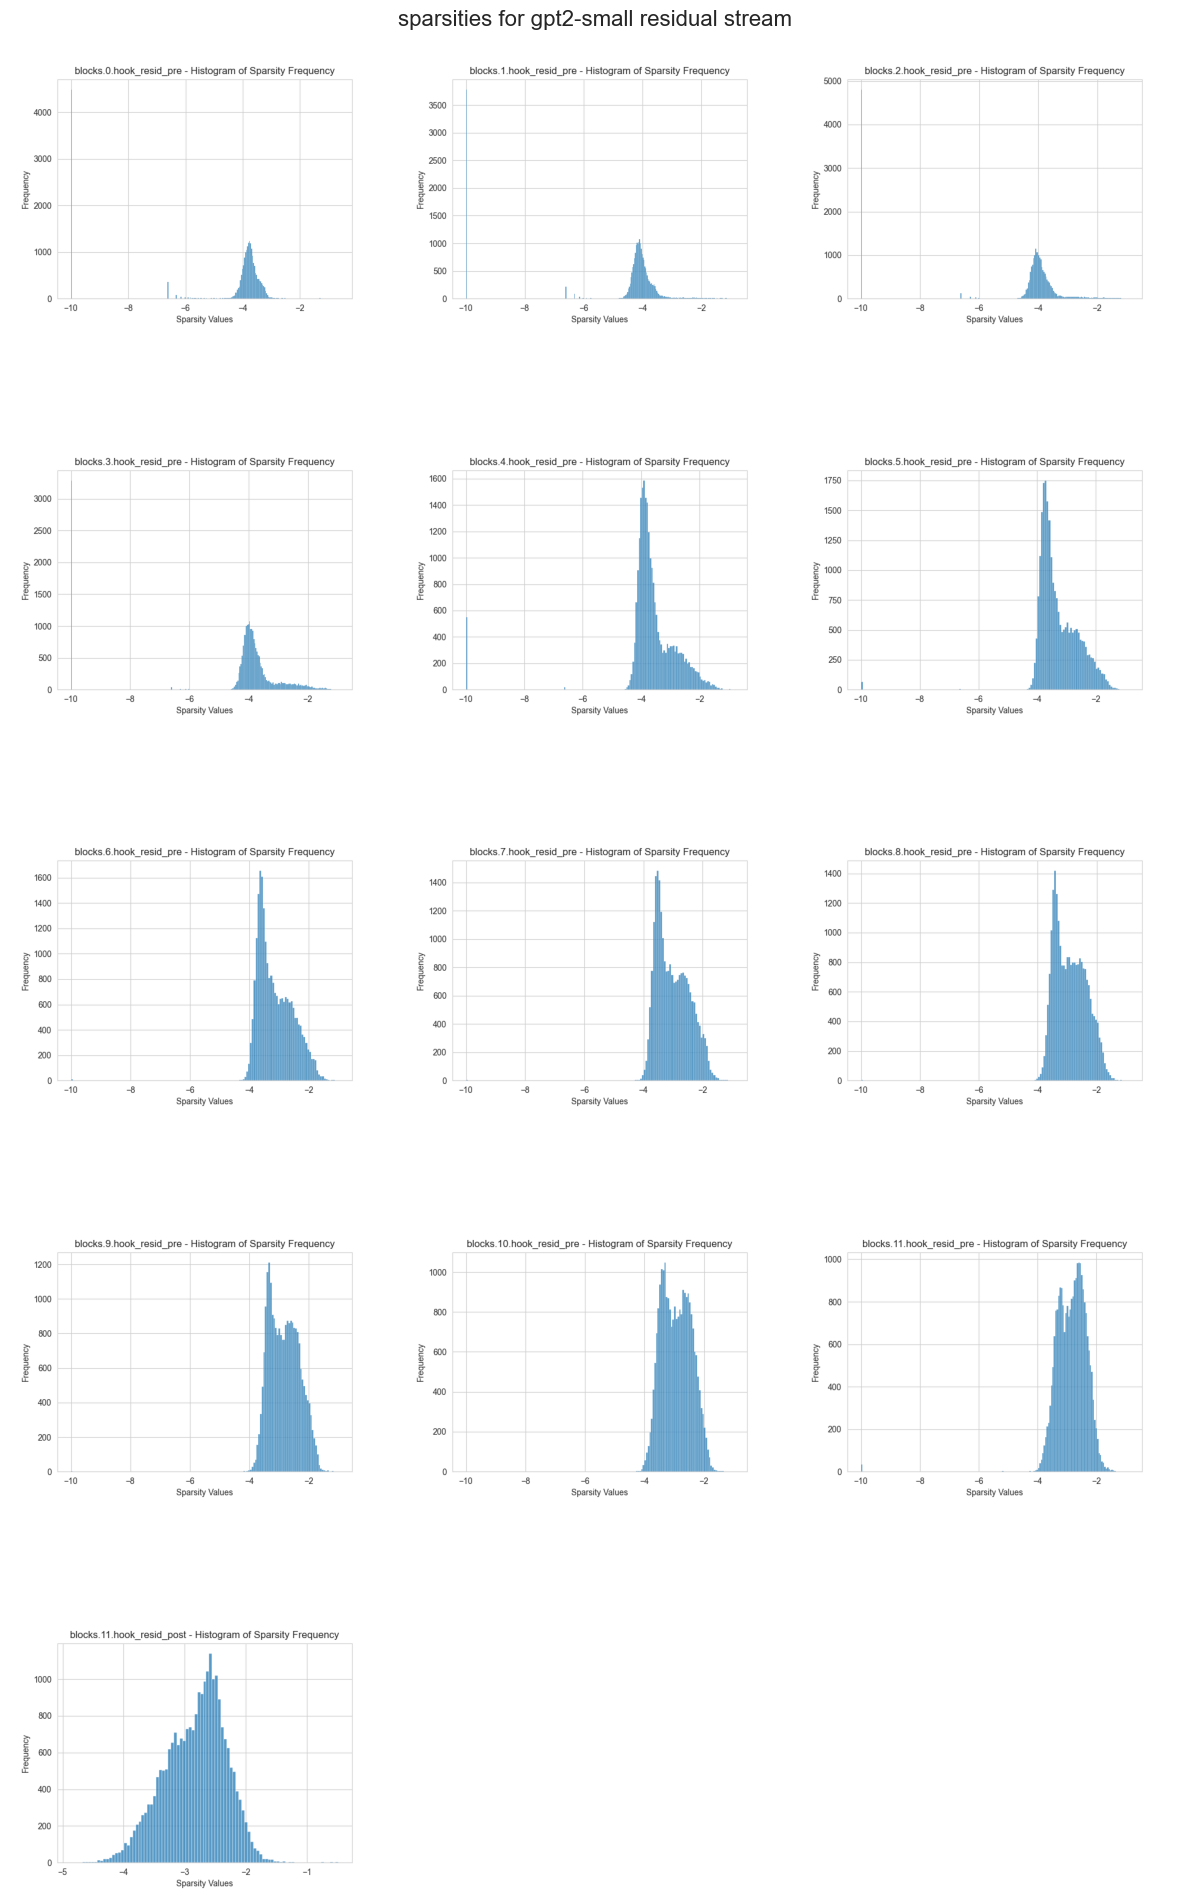

In [53]:
def make_histogram(sparsity, title):
    # Convert the tensor to a numpy array
    sparsity_np = sparsity.numpy()

    # Create a histogram using Seaborn
    fig, ax = plt.subplots()
    sns.histplot(sparsity_np, kde=False, ax=ax)

    # Set the title and labels for the plot
    ax.set_title(title)
    ax.set_xlabel('Sparsity Values')
    ax.set_ylabel('Frequency')

    # Save the figure to a buffer
    buffer = BytesIO()
    fig.savefig(buffer, format='png')
    buffer.seek(0)

    # Close the figure to free up memory
    plt.close(fig)

    # Return the buffer containing the image data
    return buffer


def create_subplots(sparsities):
    sparsities = {k: v.cpu() for k, v in sparsities.items()}
    n_saes = len(sparsities)

    # Calculate the number of rows and columns for the subplots
    n_cols = 3
    n_rows = (n_saes + n_cols - 1) // n_cols

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4 * n_rows))

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Iterate over the sparsities and create histograms for each SAE
    for i, (name, sparsity) in enumerate(sparsities.items()):
        # Create histogram subplot
        buffer_hist = make_histogram(sparsity, f"{name} - Histogram of Sparsity Frequency")
        axes[i].imshow(plt.imread(buffer_hist))
        axes[i].axis('off')

    # Remove any excess subplots
    for i in range(n_saes, n_rows * n_cols):
        fig.delaxes(axes[i])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Return the figure
    fig.suptitle(f'sparsities for gpt2-small residual stream', fontsize=16)

    return fig


fig = create_subplots(sparsities)